# Project 3 - Regression Models

A regression model provides a function that describes the relationship between one or more independent variables and a response, dependent, or target variable.

For example, the relationship between height and weight may be described by a linear regression model. A regression analysis is the basis for many types of prediction and for determining the effects on target variables. When you hear about studies on the news that talk about fuel efficiency, or the cause of pollution, or the effects of screen time on learning, there is often a regression model being used to support their claims.

**Linear regression** is a model where the relationship between inputs and outputs is a straight line. This is the easiest to conceptualize and even observe in the real world. Even when a relationship isn’t very linear, our brains try to see the pattern and attach a rudimentary linear model to that relationship.

**Multiple regression** indicates that there are more than one input variables that may affect the outcome, or target variable. For these models, it is important to understand exactly what effect each input has and how they combine to produce the final target variable results.

# Libraries

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Import Data

In [3]:
housingData_df = pd.read_csv("housingData.csv")

In [4]:
housingData_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#housingData_df.info()

# Clean the Data

Start by checking for null values.

In [6]:
housingData_df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

To get a better look at the missing data, we  can calculate the percentage of missing data for each column.

In [7]:
#missing data
total = housingData_df.isnull().sum().sort_values(ascending=False)
percent = (housingData_df.isnull().sum()/housingData_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


Lets first consider dropping all variables with more than 15% missing data:
- `PoolQC`
-`MiscFeature`
-`Alley`
-`Fence`
-`FireplaceQu`
-`LotFrontage`

None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house. Moreover, looking closer at these variables, we could say that variables like `PoolQC`, `MiscFeature` and `FireplaceQu` are strong candidates for outliers, so we'll be happy to delete them.

All of the `GarageXXXX` variables have the same number of missing data, these probably refer to the same set of observations. Since the most important information regarding garages is contained in `GarageCars` and considering that we are just talking about 5% of missing data, I'll delete the mentioned `GarageXXXX` variables. The same logic applies to `BsmtXXXX` variables.

Regarding `MasVnrArea` and `MasVnrType`, we can consider that these variables are not essential. Furthermore, they have a strong correlation with `YearBuilt` and `OverallQual` which are already considered. Thus, we will not lose information if we delete `MasVnrArea` and `MasVnrType`.

Finally, we have one missing observation in `Electrical`. Since it is just one observation, we'll delete this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable `Electrical`. In `Electrical` we'll just delete the observation with missing data.

In [8]:
#dealing with missing data
housingData_df = housingData_df.drop((missing_data[missing_data['Total'] > 1]).index,1) # delete columns from missing_data list with more 1 missing value
housingData_df = housingData_df.drop(housingData_df.loc[housingData_df['Electrical'].isnull()].index) # delete the single observation with missing data
housingData_df.isnull().sum().max() #just checking that there's no missing data missing...

/var/folders/24/536gs7r91qzd964t2ppqhs6m0000gn/T/ipykernel_52526/4118091936.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  housingData_df = housingData_df.drop((missing_data[missing_data['Total'] > 1]).index,1) # delete columns from missing_data list with more 1 missing value


0

In [9]:
housingData_df.shape

(1459, 63)

In [10]:
housingData_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

# Explortory Data Analysis

In [11]:
housingData_df.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,730.054832,56.881426,10517.363948,6.100069,5.575737,1971.244003,1984.850583,443.943797,46.581220,567.366004,...,94.240576,46.692255,21.969157,3.411926,15.071282,2.760795,43.518849,6.322824,2007.815627,180930.394791
std,421.411181,42.310746,9984.666267,1.383171,1.113079,30.199555,20.644343,456.106417,161.369977,441.992392,...,125.381679,66.267472,61.137400,29.327247,55.775138,40.191018,496.291826,2.704331,1.328542,79468.964025
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.500000,20.000000,7549.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129950.000000
50%,730.000000,50.000000,9477.000000,6.000000,5.000000,1973.000000,1994.000000,384.000000,0.000000,479.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1094.500000,70.000000,11603.000000,7.000000,6.000000,2000.000000,2004.000000,712.500000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Interesting facts about the Sale Price:**

- There are 1,459 data points for the`Sale Price` column.
- The minimum and maximum selling price are `$34,900` and `$755,000` respectively.
- The mean selling price is `$180,930`.
- The 25th and 75th percentile are are `$129,950` and `$214,000` respectively.
- The median selling price is `$163,000`.


**Pairwise relationships between continuous variables**

We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:

- To keep the model simple and improve interoperability (with many features, we run the risk of overfitting).
- When our datasets are very large, using fewer features can drastically speed up our computation time.

To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the pandas package.

To quantify the pairwise relationships that we observed in the correlation matrix, we compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:

- |0.2| = weak
- |0.5| = medium
- |0.8| = strong
- |0.9| = very strong

<AxesSubplot:title={'center':'Correlation Heatmap'}>

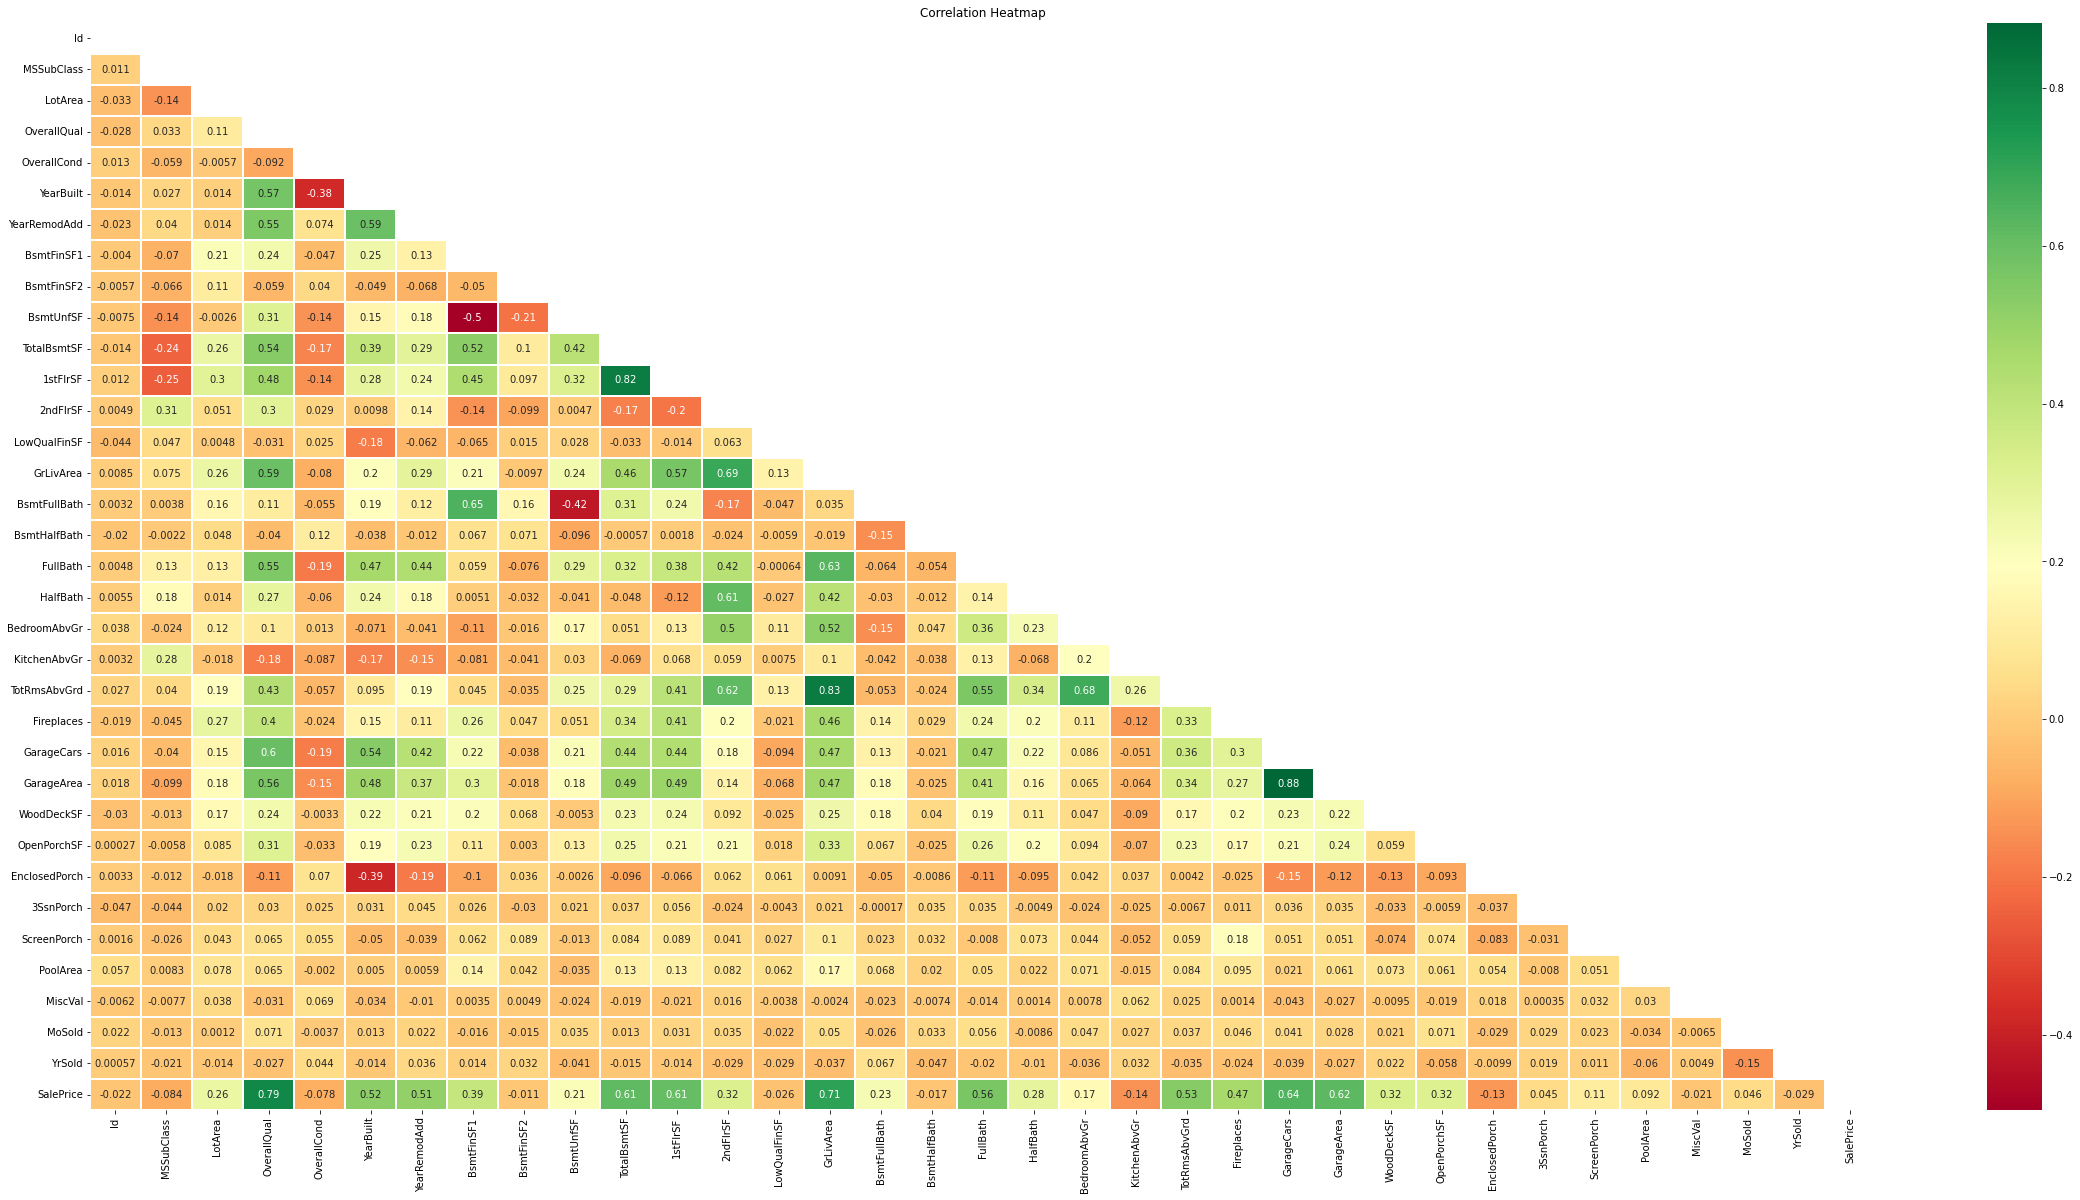

In [12]:
# Create a correlation matrix
mask = np.zeros_like(housingData_df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (40,20))
plt.title('Correlation Heatmap')
sns.heatmap(housingData_df.corr(), mask=mask, annot=True, cmap="RdYlGn", linewidths=2)

The highest correlated variables to `SalePrice` are:
- `OverallQual`
- `GrLivArea`
- `GarageCars`
- `GarageArea`
- `TotalBsmtSF`
- `1stFlrSF`
- `FullBath`
- `TotRmsAbvGrd`
- `YearBuilt`
- `YearRemodAdd`

Text(0.5, 1.0, 'OverallQual Vs. SalePrice')

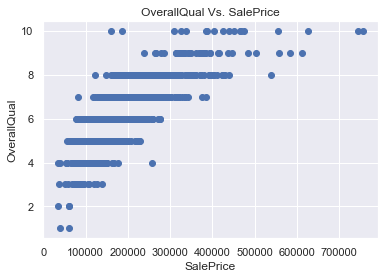

In [13]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['OverallQual'])
plt.ylabel('OverallQual')
plt.xlabel('SalePrice')
plt.title('OverallQual Vs. SalePrice')

Text(0.5, 1.0, 'GrLivArea Vs. SalePrice')

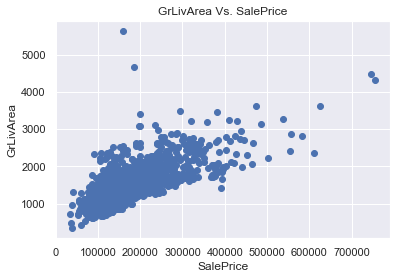

In [14]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['GrLivArea'])
plt.ylabel('GrLivArea')
plt.xlabel('SalePrice')
plt.title('GrLivArea Vs. SalePrice')

Text(0.5, 1.0, 'GarageCars Vs. SalePrice')

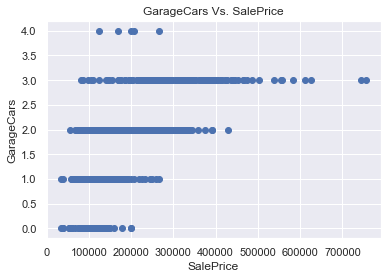

In [15]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['GarageCars'])
plt.ylabel('GarageCars')
plt.xlabel('SalePrice')
plt.title('GarageCars Vs. SalePrice')

Text(0.5, 1.0, 'GarageArea Vs. SalePrice')

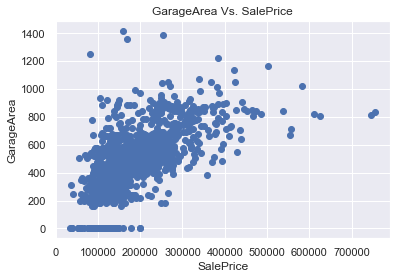

In [16]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['GarageArea'])
plt.ylabel('GarageArea')
plt.xlabel('SalePrice')
plt.title('GarageArea Vs. SalePrice')

Text(0.5, 1.0, 'TotalBsmtSF Vs. SalePrice')

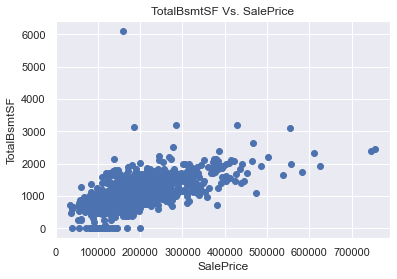

In [17]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['TotalBsmtSF'])
plt.ylabel('TotalBsmtSF')
plt.xlabel('SalePrice')
plt.title('TotalBsmtSF Vs. SalePrice')

Text(0.5, 1.0, '1stFlrSF Vs. SalePrice')

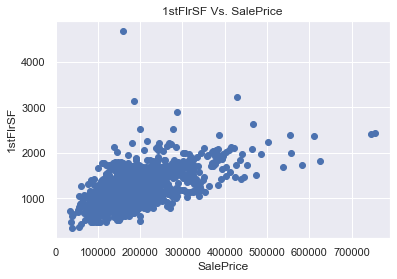

In [18]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['1stFlrSF'])
plt.ylabel('1stFlrSF')
plt.xlabel('SalePrice')
plt.title('1stFlrSF Vs. SalePrice')

Text(0.5, 1.0, 'TotRmsAbvGrd Vs. SalePrice')

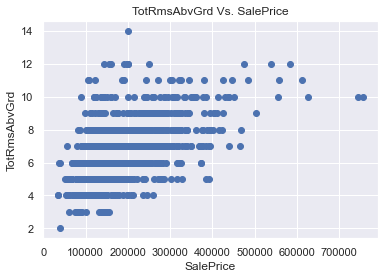

In [19]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['TotRmsAbvGrd'])
plt.ylabel('TotRmsAbvGrd')
plt.xlabel('SalePrice')
plt.title('TotRmsAbvGrd Vs. SalePrice')

Text(0.5, 1.0, 'YearBuilt Vs. SalePrice')

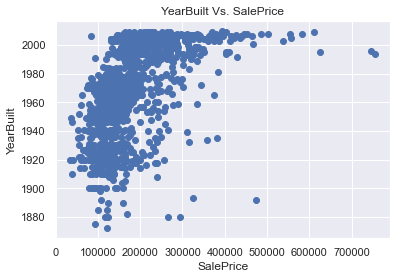

In [20]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['YearBuilt'])
plt.ylabel('YearBuilt')
plt.xlabel('SalePrice')
plt.title('YearBuilt Vs. SalePrice')

Text(0.5, 1.0, 'YearRemodAdd Vs. SalePrice')

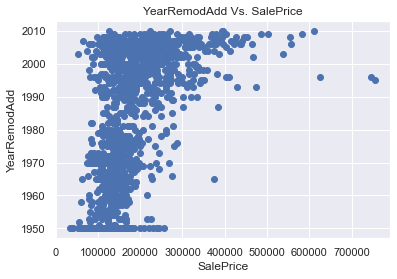

In [21]:
sns.set_theme(style="darkgrid")
plt.scatter(housingData_df['SalePrice'], housingData_df['YearRemodAdd'])
plt.ylabel('YearRemodAdd')
plt.xlabel('SalePrice')
plt.title('YearRemodAdd Vs. SalePrice')

---
---
# Regrression Models

**Regression models** provides a function that describes the relationship between one or more independent variables and a response, dependent, or target variable.

For example, the relationship between height and weight may be described by a linear regression model. A regression analysis is the basis for many types of prediction and for determining the effects on target variables. When you hear about studies on the news that talk about fuel efficiency, or the cause of pollution, or the effects of screen time on learning, there is often a regression model being used to support their claims.

## Simple Linear Regression

**Linear regression** is a model where the relationship between inputs and outputs is a straight line. This is the easiest to conceptualize and even observe in the real world. Even when a relationship isn’t very linear, our brains try to see the pattern and attach a rudimentary linear model to that relationship.

In [22]:
# To begin we will run our models using just the numerical data.
X_lre = housingData_df.select_dtypes(exclude='object').copy()
X_lre.head(20)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000
5,6,50,14115,5,5,1993,1995,732,0,64,...,40,30,0,320,0,0,700,10,2009,143000
6,7,20,10084,8,5,2004,2005,1369,0,317,...,255,57,0,0,0,0,0,8,2007,307000
7,8,60,10382,7,6,1973,1973,859,32,216,...,235,204,228,0,0,0,350,11,2009,200000
8,9,50,6120,7,5,1931,1950,0,0,952,...,90,0,205,0,0,0,0,4,2008,129900
9,10,190,7420,5,6,1939,1950,851,0,140,...,0,4,0,0,0,0,0,1,2008,118000


In [23]:
# There all too many columns with value 0, which represents that the value doesn't exist
# Hence, to simplify, we replace all the 0 values with NaN and drop all columns with NaN values
X_lre = X_lre.replace(0,np.nan).dropna(axis = 1)
X_lre

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,GrLivArea,TotRmsAbvGrd,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,856,1710,8,2,2008,208500
1,2,20,9600,6,8,1976,1976,1262,1262,6,5,2007,181500
2,3,60,11250,7,5,2001,2002,920,1786,6,9,2008,223500
3,4,70,9550,7,5,1915,1970,961,1717,7,2,2006,140000
4,5,60,14260,8,5,2000,2000,1145,2198,9,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,953,1647,7,8,2007,175000
1456,1457,20,13175,6,6,1978,1988,2073,2073,7,2,2010,210000
1457,1458,70,9042,7,9,1941,2006,1188,2340,9,5,2010,266500
1458,1459,20,9717,5,6,1950,1996,1078,1078,5,4,2010,142125


In [24]:
X_slr = X_lre[['OverallQual']]
y = X_lre['SalePrice']
train_x, valid_x, train_y, valid_y = train_test_split(X_slr, y, train_size = 0.7, random_state = 42)

simple_linear = LinearRegression()
simple_linear.fit(train_x, train_y)

prediction = simple_linear.predict(valid_x)

rmse_simple = mean_squared_error(prediction, valid_y, squared = False)
print('RMSE Simple Linear Regression: ', round(rmse_simple, 2))

RMSE Simple Linear Regression:  46218.03


##### Simple Linear Regression Summary

Using **Simple Linear Regression**, we get a root mean square error of $46,218 and this is an unusually high value. So, we will now use Multiple Linear Regression and see if we can reduce this error!


In [25]:
import statsmodels.api as sm

In [26]:
X2 = sm.add_constant(train_x)

In [27]:
est = sm.OLS(train_y, X2)

In [28]:
est2 = est.fit()

In [29]:
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1597.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          7.67e-211
Time:                        15:23:22   Log-Likelihood:                -12487.
No. Observations:                1021   AIC:                         2.498e+04
Df Residuals:                    1019   BIC:                         2.499e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.782e+04   7151.051    -13.679      0.000   -1.12e+05   -8.38e+04
OverallQual  4.555e+04   1139.929     39.962      0.000    4.33e+04    4.78e+04
==============================================================================
Omnibus:                      418.036   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3699.560
Skew:                           1.637   Prob(JB):                         0.00
Kurtosis:                      11.732   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
## Multiple Linear Regression

**Multiple regression** indicates that there are more than one input variables that may affect the outcome, or target variable. For these models, it is important to understand exactly what effect each input has and how they combine to produce the final target variable results.

In [30]:
#first lets choose the columns with the highest linear correlation with SalePrice 
X_mlr = X_lre[['LotArea','OverallQual','YearBuilt','YearRemodAdd','1stFlrSF','GrLivArea','TotRmsAbvGrd']]

X_train, X_valid, y_train, y_valid = train_test_split(X_mlr, y, train_size=0.7, random_state = 42)
                                                      

multiple_linear = LinearRegression()
multiple_linear.fit(X_train, y_train)
prediction1 = multiple_linear.predict(X_valid)

rmse_multiple = mean_squared_error(prediction1, y_valid, squared = False)
print('RMSE Multiple Linear Regression: ', round(rmse_multiple, 2))

RMSE Multiple Linear Regression:  33294.46


**Multiple Linear Regression Summary**

As expected, with **Multiple Linear Regression** we got a lower RMSE ($33,294) than **Simple Linear Regression**. We can try to improve our model more by using Decision Tree Regressor.

---
## Decision Tree Regression

**Decision tree regression** observes features of an object and trains a model in the structure of a tree to predict data in the future to produce meaningful continuous output. Continuous output means that the output/result is not discrete, i.e., it is not represented just by a discrete, known set of numbers or values.

In [31]:
# Function to find best result based on Max leaf nodes
def get_rmse_dtr(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 42)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    rmse = mean_squared_error(val_y, preds_val, squared = False)
    return(round(rmse, 2))

In [32]:
# We will use same columns from Multiple Linear Regression as indepentant/ explanatory variable
# Find the ideal tree size from candidate_max_leaf_nodes
scores = {leaf_size: get_rmse_dtr(leaf_size, X_train, X_valid, y_train, y_valid) for leaf_size in range(5,1000,50)}
best_tree_size = min(scores, key = scores.get)

rmse_decision = scores[best_tree_size]
print('Best result at max leaf nodes : ', best_tree_size)
print('RMSE for Decision Tree Regressor: ', rmse_decision)

Best result at max leaf nodes :  55
RMSE for Decision Tree Regressor:  36766.17


**Decision Tree Regressor Summary**

The Decision Tree Regressor didn't get better results and the RMSE increases to $36,766. We can now try improving our model by using Random Forest Regressor.


---
## Random Forest Regression

In [33]:
#function to find best result based on n_estimators
def get_rmse_rfr(n_estimators, train_X, val_X, train_y, val_y):
    model = RandomForestRegressor(n_estimators = n_estimators, random_state = 42)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    rmse = mean_squared_error(val_y, preds_val, squared = False)
    return(round(rmse, 2))

In [34]:
# Will use same column from Multiple Linear Regression as indepentant/ explanatory variable
# Find the ideal tree size from candidate_max_leaf_nodes
scores = {leaf_size: get_rmse_rfr(leaf_size, X_train, X_valid, y_train, y_valid) for leaf_size in range(5,1000,50)}
best_tree_size = min(scores, key = scores.get)

rmse_forest = scores[best_tree_size]
print('Best result at max leaf nodes : ',best_tree_size)
print('RMSE for Decision Tree Regressor: ', rmse_forest)

Best result at max leaf nodes :  305
RMSE for Decision Tree Regressor:  28806.23


**Random Forest Regressor Summary**

We get much better results with the Random Forest Regressor, and the RMSE decreases to $28,806. We can now try improving our model by using Gradient Boosting.


---
## Gradient Boosting with XGBoost

In general, gradient boosting is a supervised machine learning method for classification as well as regression problems. The overarching strategy involves producing a statistical learning model in the form of an ensemble of weak models, normally decision trees.

The learning process for gradient boosting models involves sequentially fitting new models to provide a more finely tuned estimate of the response variable. The principal idea behind this algorithm is to create new base-learners that are correlated with the negative gradient of the loss function that’s associated with the entire ensemble.

In [35]:
my_model_3 = XGBRegressor(n_estimators=350, learning_rate=0.05)

# Fit the model
my_model_3.fit(X_train,y_train)              
predictions_3 = my_model_3.predict(X_valid)

# Calculate RMSE
rmse_xg = mean_squared_error(predictions_3, y_valid, squared = False)

print("RMSE for XGBoost:" , round(rmse_xg, 2))

RMSE for XGBoost: 30252.98


**Gradient Boosting with XGBoost Summary**

Using Gradient Boosting, we don't get any better results than Random Forest Regressor and the RMSE increases slighly to $30,252.


---
## Regression Models Summary

- Tested 5 different Machine Learning Models: Simple Linear Regression, Multiple Linear Regression, Decision Tree Regressor, Random Forest Regressor, and Gradient Boosting with XGBoost.
- Of the 4 models, Random Forest Regressor performs the best and gives the least RMSE of `$28,806`.
- Simple Linear Regression performs the worst with the maximum RMSE of `$46,218`.
- As expected, Simple Linear Regression fails to capture the complexity of the dataset and heavily overfits on a single explanatory variable thereby resulting in a high RMSE.

---
---
# Model Evaluation and Optimization

Until now, we only used Numerical columns, so to optimize the model, we will use both Categorical and Numerical columns.

## Including categorical features

Creating a training, validation, and test data that contains both features: Categorical and Numerical.

In [36]:
# Break off validation set from training data
y = housingData_df.SalePrice
housingData_df.drop(['SalePrice'], axis = 1, inplace = True)

X_train_optimize, X_valid_optimize, y_train, y_valid = train_test_split(housingData_df, y, train_size = 0.7, random_state = 42)
                                                                                                                  
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_optimize.columns if
                    X_train_optimize[cname].nunique() < 10 and 
                    X_train_optimize[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_optimize.columns if 
                X_train_optimize[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_optimize[my_cols].copy()
X_valid = X_valid_optimize[my_cols].copy()
X_test = housingData_df[my_cols].copy()

### Optimizing for minimum RMSE

In [37]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model= XGBRegressor(n_estimators=350, learning_rate=0.05)
# Bundle preprocessing and modeling code in a pipeline
pipe_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
pipe_model.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = pipe_model.predict(X_valid)

rmse_optimize = mean_squared_error(y_valid, preds, squared = False)
print('RMSE after model opimization:', round(rmse_optimize, 2))

RMSE after model opimization: 23152.74


**Optimized Gradient Boosting with XGBoost Summary**

Optimizing the Gradient Boost Model, we get the best results yet and the RMSE decreases slighly to $23,152.


# Compare the models

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. Root mean square error is commonly used in climatology, forecasting, and regression analysis to verify experimental results.

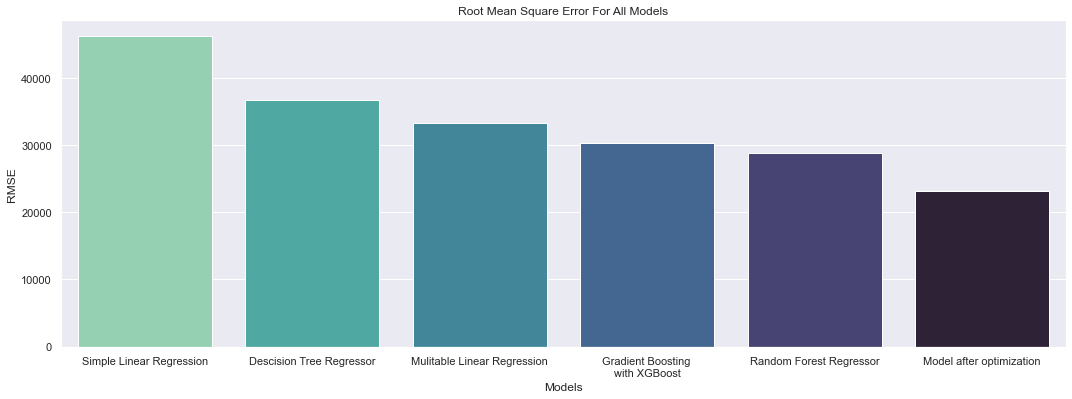

In [38]:

# Create a dataframe containing the RMSE values from each model
compare = pd.DataFrame({'Model': ['Simple Linear Regression', 'Mulitable Linear Regression', 'Descision Tree Regressor',
                                  'Random Forest Regressor', 'Gradient Boosting \nwith XGBoost', 'Model after optimization'], 
                        'RMSE': [rmse_simple, rmse_multiple, rmse_decision, rmse_forest, rmse_xg, rmse_optimize]})
compare.sort_values(by='RMSE', ascending=False)

# Plot the RSME Values
plt.figure(figsize=(18,6))
sns.barplot(data=compare.sort_values(by='RMSE', ascending=False),x='Model',y='RMSE', palette="mako_r")
plt.title('Root Mean Square Error For All Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()

